In [1]:
from preprocessing_for_adult import preprocessing_funct_not_enc, encoding_funct, K_subgroups_dataset_and_or, metrics_to_compare,encoding_funct_SMOTE
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import torch

from divexplorer import DivergenceExplorer
from divexplorer import DivergencePatternProcessor

from divexplorer.outcomes import get_false_negative_rate_outcome


In [2]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv("adult.data", header = None, names = col_names)


In [3]:
seed = 42
pd.options.display.float_format = '{:.3f}'.format


In [4]:
epsilon = 0.01

In [5]:
min_sup = 0.4
percentage =  15


In [6]:
df_train, df_val, df_test, df_holdout = preprocessing_funct_not_enc(df)
#controllo divisione dataset
print(f"TRAIN SET ROWS: ", df_train.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout.shape[0])
print(f"TEST SET ROWS: ", df_test.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


In [7]:
df_train_enc, df_test_enc, df_holdout_enc, df_val_enc = encoding_funct(df_train=df_train, df_test=df_test, df_holdout=df_holdout, df_val=df_val)
#controllo coerenza con numerosità precedente
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val_enc.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout_enc.shape[0])
print(f"TEST SET ROWS: ", df_test_enc.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


In [8]:
#GDecisioN tree predictions
X_train = df_train_enc.drop(columns = 'income', axis = 1)
y_train = df_train_enc['income']

X_test = df_test_enc.drop(columns = 'income', axis = 1)
y_test = df_test_enc['income']

X_val = df_val_enc.drop(columns = 'income', axis = 1)
y_val = df_val_enc['income']

X_holdout = df_holdout_enc.drop(columns = 'income', axis = 1)
y_holdout = df_holdout_enc['income']

classifier_train = LogisticRegression(random_state=seed)
classifier_train.fit(X_train, y_train)
y_pred = classifier_train.predict(X_test)
cm_classifier = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_classifier, display_labels=[False, True])
#disp.plot()
#plt.show()

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before = metrics_to_compare(y_true = y_test, y_pred = y_pred )
metrics_before_df = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test)],
})
metrics_before_df = metrics_before_df.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Test Size']

for metric in metrics_to_cast:
    metrics_before_df[metric] = metrics_before_df[metric].astype(int)

metrics_before_df

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,6508


SUBGROUPS SEARCH

-Identifico i gruppi applicando DivExplorer sul validation not encoded (a cui ho aggiunto la feature sui falsi positivi da passare a boolean outcomes e la feature accuracy che vale 1 se la predizione è giusta e 0 se sbagliata )

-Integro nel training set dati che matchano sottogruppi problematici prendendoli dall'holdout, (primi K = 5, tutte le righe holdout che matchano)

-Ripeto training e test

In [10]:
#predizioni per il validation set
y_pred_val_dt = classifier_train.predict(X_val)

df_val_class = X_val.copy()
df_val_class['y_val_true'] = y_val
df_val_class['y_pred'] = y_pred_val_dt

df_val_class.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,age_group,edu_num_group,hours_per_week_group,y_val_true,y_pred
18761,2,0.077,3,0,4,1,4,0,0.000,0.000,5,2,1,1,0,0
27582,3,0.048,3,1,4,0,4,1,0.000,0.000,5,5,1,2,1,0
30911,2,0.174,3,3,4,4,2,0,0.039,0.000,5,1,1,1,0,0
11128,0,0.012,2,1,2,0,2,1,0.000,0.507,5,3,4,1,1,1
683,0,0.284,3,3,2,4,2,1,0.000,0.000,5,0,1,1,0,0


In [11]:
y_trues = df_val_class["y_val_true"]
y_preds = df_val_class["y_pred"]

df_val_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_val['fn'] = df_val_class['fn']

#aggiungo la feature accuracy a df_val non encoded che assume valore 1 se la predizione è giusta 0 se la predizione è sbagliata
#come controllo che sia corretto aggiungo la feature y_pred 
df_val['y_pred'] = df_val_class['y_pred'] 
df_val['accuracy'] = (df_val_class['y_val_true']==df_val_class['y_pred']).astype(int)
df_val.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,income,age_group,edu_num_group,hours_per_week_group,fn,y_pred,accuracy
18761,Private,0.077,Non Graduated,Divorced,Self-emp-occ,Not-in-family,White,Female,0.000,0.000,United-States,0,35-44,10 College,Overtime,NaN,0,1
27582,Self-emp,0.048,Non Graduated,Married,Self-emp-occ,Husband,White,Male,0.000,0.000,United-States,1,65-100,10 College,Part-time,1.000,0,0
30911,Private,0.174,Non Graduated,Separated,Self-emp-occ,Unmarried,Black,Female,0.039,0.000,United-States,0,25-34,10 College,Overtime,NaN,0,1
11128,Government,0.012,Master's Degree,Married,Private-occ,Husband,Black,Male,0.000,0.507,United-States,1,45-54,14 Master's Degree,Overtime,0.000,1,1
683,Government,0.284,Non Graduated,Separated,Private-occ,Unmarried,Black,Male,0.000,0.000,United-States,0,17-24,10 College,Overtime,NaN,0,1


In [12]:
fp_diver = DivergenceExplorer(df_val)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by=["fn_div", "fn_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
FP_fm.head()

,support,itemset,fn,fn_div,fn_t,length,support_count
0,0.453,"(workclass=Private, education=Non Graduated, capital-loss=0.0, capital-gain=0.0)",0.991,0.323,24.196,4,2945.000
1,0.442,"(hours_per_week_group=Overtime, education=Non Graduated, capital-loss=0.0, capital-gain=0.0)",0.977,0.309,22.001,4,2878.000
2,0.508,"(education=Non Graduated, race= White, capital-loss=0.0, capital-gain=0.0)",0.968,0.300,20.269,4,3306.000
3,0.608,"(education=Non Graduated, capital-loss=0.0, capital-gain=0.0)",0.967,0.299,20.556,3,3958.000
4,0.464,"(education=Non Graduated, native-country=United-States, capital-gain=0.0, race= White, capital-loss=0.0)",0.967,0.299,19.946,5,3021.000


In [13]:
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values("fn_div", ascending=False)
df_pruned_fp.head()

,support,itemset,length,support_count,fn,fn_div,fn_t
0,0.453,"(workclass=Private, education=Non Graduated, capital-loss=0.0, capital-gain=0.0)",4,2945.000,0.991,0.323,24.196
1,0.442,"(hours_per_week_group=Overtime, education=Non Graduated, capital-loss=0.0, capital-gain=0.0)",4,2878.000,0.977,0.309,22.001
3,0.608,"(education=Non Graduated, capital-loss=0.0, capital-gain=0.0)",3,3958.000,0.967,0.299,20.556
8,0.471,"(workclass=Private, education=Non Graduated, capital-gain=0.0)",3,3062.000,0.946,0.278,16.434
12,0.632,"(education=Non Graduated, capital-gain=0.0)",2,4113.000,0.929,0.260,15.863


In [14]:
# Numero totale di istanze
total_instances = len(df_pruned_fp)

# Numero di istanze con fp_div > 0 e fp_t > 2
filtered_instances = len(df_pruned_fp[(df_pruned_fp['fn_div'] > 0) & (df_pruned_fp['fn_t'] > 2)])

print('total subgroups', total_instances)
print('total problematic', filtered_instances)

total subgroups 34
total problematic 27


In [15]:
prun_size = df_pruned_fp.shape
original_size = FP_fm.shape
print("Dim original: ", original_size)
print("Dim pruned th_redundancy ", prun_size)

Dim original:  (147, 7)
Dim pruned th_redundancy  (34, 7)


In [16]:
K = int((percentage / 100) * filtered_instances)
K

4

BIAS MITIGATION: ADDING DATA: prendo dati dall'hold-out e li aggiungo al train set, questi dati matchano gli itemset trovati prima (i primi 5)

1. prendo dati dall'holdout con la funzione K_subgroups_dataset3 li aggiungo train 
2. riapplico encoding tutto
3. Decision tree nuovamente e vedo come sono cambiate le performance (ad es Accuracy, false positive rate, false negative rate) overall e per sottogruppi

In [17]:
df_holdout_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_holdout, K) #da aggiungere a train set e ripetere train e test
print('prima', len(df_holdout_filtered))
df_holdout_filtered_solo1 = df_holdout_filtered[df_holdout_filtered['income']==1]



df_combinated = pd.concat([df_holdout_filtered_solo1, df_train], ignore_index=True)
df_train_mitigated= df_combinated.sample(frac=1, random_state=seed).reset_index(drop=True)

df_holdout_filtered = df_holdout_filtered_solo1 

print("dopo", len(df_holdout_filtered))

prima 4059
dopo 511


In [18]:
#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, inutile1, inutile3, inutile2 = encoding_funct(df_train=df_train_mitigated, df_test=df_test, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_fp = df_train_enc_mit  
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", inutile1.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", inutile3.shape[0])
print(f"TEST SET FILTERED ROWS: ", inutile2.shape[0])

TRAIN SET ROWS:  13014
TRAIN SET MITIGATED ROWS:  13525
VALIDATION SET ROWS:  6508
FILTERED DF holdout ROWS:  511
TEST SET FILTERED ROWS:  6507


In [19]:

X_train_mitigated = df_train_enc_mit.drop(columns = 'income', axis = 1)
y_train_mitigated = df_train_enc_mit['income']


classifier_train_mitigated = LogisticRegression(random_state=seed)

classifier_train_mitigated.fit(X_train_mitigated, y_train_mitigated)
y_mitigated_pred = classifier_train_mitigated.predict(X_test)
cm_dt = confusion_matrix(y_test, y_mitigated_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[False, True])
#disp.plot()
#plt.show()

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
#per veriicare cosa accade se aggiungo in modo randomico lo stesso numero di righe al train, ripeto l'analisi facebdo mitigation con righe randomiche (uguali in numero)
print(len(df_holdout_filtered))
n = len(df_holdout_filtered)
df_holdout_sampled = df_holdout_enc.sample(n=len(df_holdout_filtered), replace=True, random_state=seed)
print("verifica :", len(df_holdout_sampled)) #verifica



df_combinated_random = pd.concat([df_holdout_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random= df_combinated_random.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random = df_train_mitigated_random.drop(columns="income", axis = 1)
y_train_mitigated_random = df_train_mitigated_random['income']

classifier_train_mitigated_random = LogisticRegression(random_state=seed)

classifier_train_mitigated_random.fit(X_train_mitigated_random, y_train_mitigated_random)
y_mitigated_pred_random = classifier_train_mitigated_random.predict(X_test)

511
verifica : 511


/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:

accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred )
accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random= metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random)

metrics_after_fp = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After Mitigation(K=5, fp)': [accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after, len(y_train_mitigated), len(y_test)],
    'After RANDOM mitigation' : [accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random, len(y_train_mitigated_random), len(y_test)]
})
metrics_after_fp = metrics_after_fp.set_index('Metrics').T



metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp[metric] = metrics_after_fp[metric].astype(int)
print("Overall Gradient Boosting performance when boolean outcomes = fn ")
metrics_after_fp

Overall Gradient Boosting performance when boolean outcomes = fn 


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
"After Mitigation(K=5, fp)",0.807,0.506,0.066,0.591,327,927,13525,6508
After RANDOM mitigation,0.809,0.476,0.049,0.640,240,1003,13525,6508


In [22]:
df_test_filtered_fp = K_subgroups_dataset_and_or(df_pruned_fp, df_test, K)
inutile, df_test_filtered_enc_fp, inutile2, inutile3 = encoding_funct(df_train, df_test_filtered_fp, df_holdout, df_val)

X_test_filtered_fp = df_test_filtered_enc_fp.drop(columns='income', axis = 1)
y_true_test_filtered_fp = df_test_filtered_enc_fp['income']

y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after = classifier_train_mitigated.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_random = classifier_train_mitigated_random.predict(X_test_filtered_fp)

accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after )
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_random)


metrics_after_fp_sottogruppi = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after, len(y_train_mitigated), len(y_pred_test_filtered_fp_after)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(y_train_mitigated_random), len(y_pred_test_filtered_fp_after_random)]
})
metrics_after_fp_sottogruppi = metrics_after_fp_sottogruppi.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi[metric] = metrics_after_fp_sottogruppi[metric].astype(int)

metrics_after_fp


print("Subgroups Decision Tree performance when boolean outcomes = fn")
metrics_after_fp_sottogruppi

Subgroups Decision Tree performance when boolean outcomes = fn


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.874,0.081,0.009,0.955,32,489,13014,4135
"After Mitigation(K=5, on subgroups, fp)",0.866,0.180,0.028,0.881,103,451,13525,4135
"After RANDOM Mitigation(K=5, on subgroups, fp)",0.874,0.081,0.009,0.955,32,489,13525,4135


ANALISI DIVERGENZE

Per vedere cosa accade ai sottogruppi: vedo cosa succede alle divergenze del test dopo la mitigation

In [23]:
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(["fn_div", "fn_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values("fn_div", ascending=False)
df_pruned_fp.head()



fn_div_list_no_mitigation  = df_pruned_fp["fn_div"].tolist()
#fn_div_list_no_mitigation


In [24]:
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred 

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values("fn_div", ascending=False)
df_pruned_fp.head()



fn_div_list_baseline1  = df_pruned_fp["fn_div"].tolist()
#fn_div_list_baseline1


In [25]:
#PER VEDERE COSA SUCCEDE ALLE DIVERGENZE DEI SOTTOGRUPPI CON MITIGATION RADOMICA
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(["fn_div", "fn_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values("fn_div", ascending=False)
df_pruned_fp.head()



fn_div_list_random_per_confrontare_con_baseline1  = df_pruned_fp["fn_div"].tolist()
#fn_div_list_random_per_confrontare_con_baseline1


In [26]:
# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fn_div_list_no_mitigation = np.nanmean(fn_div_list_no_mitigation)
media_fn_div_list_nomitigation_primi10 = np.nanmean(fn_div_list_no_mitigation[:10])
media_fn_div_list_nomitigation_primi20 = np.nanmean(fn_div_list_no_mitigation[:20])
media_fn_div_list_nomitigation_primi40 = np.nanmean(fn_div_list_no_mitigation[:40])
massimo_valore_assoluto_fn_div_no_mitigation = max(abs(x) for x in fn_div_list_no_mitigation)

media_fn_div_list_baseline1 = np.nanmean(fn_div_list_baseline1)
media_fn_div_list_baseline1_primi10 = np.nanmean(fn_div_list_baseline1[:10])
media_fn_div_list_baseline1_primi20 = np.nanmean(fn_div_list_baseline1[:20])
media_fn_div_list_baseline1_primi40 = np.nanmean(fn_div_list_baseline1[:40])
fn_div_massimo_valore_assoluto_fn_div_baseline1 = max(abs(x) for x in fn_div_list_baseline1)

media_fn_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fn_div_list_random_per_confrontare_con_baseline1)
media_fn_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fn_div_list_random_per_confrontare_con_baseline1[:10])
media_fn_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fn_div_list_random_per_confrontare_con_baseline1[:20])
media_fn_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fn_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fn_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fn_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fn_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fn_div_list_no_mitigation, massimo_valore_assoluto_fn_div_no_mitigation,
        media_fn_div_list_nomitigation_primi10, media_fn_div_list_nomitigation_primi20, media_fn_div_list_nomitigation_primi40, 0
    ],
    'After Mitigation(K=5 fp)': [
        accuracy_fp_after, f1_score_fp_after, media_fn_div_list_baseline1, fn_div_massimo_valore_assoluto_fn_div_baseline1,
        media_fn_div_list_baseline1_primi10, media_fn_div_list_baseline1_primi20, media_fn_div_list_baseline1_primi40, len(df_holdout_filtered)
    ],
    'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fn_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fn_div_random_per_confrontare_con_baseline1, media_fn_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fn_div_list_random_per_confrontare_con_baseline1_primi20, media_fn_div_list_random_per_confrontare_con_baseline1_primi40,
        len(df_holdout_filtered)
    ]
})

# Trasposizione per visualizzazione
divergence_after_fn_sottogruppi = divergence_after_fn_sottogruppi.set_index('Metrics').T

divergence_after_fn_sottogruppi




Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.106,0.345,0.246,0.173,0.106,0.000
After Mitigation(K=5 fp),0.807,0.506,0.112,0.351,0.272,0.228,0.153,511.000
After RANDOM Mitigation(K=5 fp),0.809,0.476,0.107,0.348,0.247,0.174,0.107,511.000


QUI INIZIA SMOTE come si deve DA METTERE NEL REPORT
BIAS MITIGATION SMOTENC

- FISSO N VARIA p, p è la probabilità che il campione simulato sia di classe 0 qui (perchè voglio diminuire il numero di falsi negativi)
- FISSO p VARIA N , aumento il numero di 0 per diminuire il numero di falsi negativi  

In [27]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_val, K)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ['fn', 'y_pred', 'accuracy', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

Righe del dataset filtrato qunado K = 5 4108


In [28]:
count_1 = df_val_filtered['income'].sum()
count_0 = len(df_val_filtered) - count_1
count_1, count_0

(534, 3574)

QUI MODIFICO FACENDO SMOTE SU DF_VAL_FILTERED 

In [29]:
'''smote_nc = SMOTENC(categorical_features=categorical_features,random_state=seed)
X_to_SMOTE, y_to_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
count_1 = y_to_SMOTE.sum()
count_0 = len(y_to_SMOTE)-count_1
count_0, count_1'''

'smote_nc = SMOTENC(categorical_features=categorical_features,random_state=seed)\nX_to_SMOTE, y_to_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)\ncount_1 = y_to_SMOTE.sum()\ncount_0 = len(y_to_SMOTE)-count_1\ncount_0, count_1'

per confronto con targeted
N come len_df_holdout_filtered

In [30]:
#p1 = 0.5
N = len(df_holdout_filtered)
original_size = len(X_to_SMOTE)
sampling_strategy = {1: count_1 + int(N*0.5), 0: count_0 + int(N*0.5)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {0: count_0 + int(N*0.6), 1: count_1 + int(N*0.4)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {0: count_0 + int(N*0.7), 1: count_1 + int(N*0.3)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {0: count_0 +int(N*0.8), 1: count_1 + int(N*0.2)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {0: count_0 + int(N*0.9), 1: count_1 + int(N*0.1)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {0: count_0 + int(N*1), 1: count_1 + int(N*0)}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
After RANDOM mitigation N = 5000,0.809,0.476,0.049,0.640,240,1003,13525,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.809,0.490,0.055,0.619,274,971,13525,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.809,0.482,0.051,0.631,254,990,13525,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.810,0.481,0.050,0.633,246,993,13525,6508
After SMOTE N = 5000 p_class 0 = 0.8,0.809,0.476,0.048,0.640,239,1004,13525,6508
After SMOTE N = 5000 p_class 0 = 0.9,0.808,0.473,0.048,0.643,239,1009,13525,6508
After SMOTE N = 4000 p_class 0 = 1,0.808,0.467,0.046,0.651,226,1021,13525,6508


In [31]:
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

In [32]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp['fn_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values(['fn_div', 'fn_t'], ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = np.nanmean(fp_div_list_baseline2_p1_5K)
media_fp_div_list_baseline2_p1_5K_primi10 = np.nanmean(fp_div_list_baseline2_p1_5K[:10])
media_fp_div_list_baseline2_p1_5K_primi20 = np.nanmean(fp_div_list_baseline2_p1_5K[:20])
media_fp_div_list_baseline2_p1_5K_primi40 = np.nanmean(fp_div_list_baseline2_p1_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = np.nanmean(fp_div_list_baseline2_p4_5K)
media_fp_div_list_baseline2_p4_5K_primi10 = np.nanmean(fp_div_list_baseline2_p4_5K[:10])
media_fp_div_list_baseline2_p4_5K_primi20 = np.nanmean(fp_div_list_baseline2_p4_5K[:20])
media_fp_div_list_baseline2_p4_5K_primi40 = np.nanmean(fp_div_list_baseline2_p4_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = np.nanmean(fp_div_list_baseline2_p6_5K)
media_fp_div_list_baseline2_p6_5K_primi10 = np.nanmean(fp_div_list_baseline2_p6_5K[:10])
media_fp_div_list_baseline2_p6_5K_primi20 = np.nanmean(fp_div_list_baseline2_p6_5K[:20])
media_fp_div_list_baseline2_p6_5K_primi40 = np.nanmean(fp_div_list_baseline2_p6_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 2K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 2K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 2K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.106,0.345,0.246,0.173,0.106,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.476,0.107,0.348,0.247,0.174,0.107,511.000
"After Mitigation(K=5 fp, N = 2K, p=0.5)",0.809,0.482,0.092,0.341,0.248,0.184,0.092,511.000
"After Mitigation(K=5 fp, N = 2K, p=0.8)",0.809,0.476,0.103,0.347,0.246,0.174,0.103,511.000
"After Mitigation(K=5 fp, N = 2K, p=1)",0.808,0.467,0.115,0.336,0.244,0.171,0.115,511.000


In [33]:
K

4

N = 2000

In [34]:
#p1 = 0.5
N = 2000
original_size = len(X_to_SMOTE)
sampling_strategy = {1: count_1 + 1000, 0: count_0 + 1000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {1: count_1 + 1200, 0: count_0 + 800}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {1: count_1 + 1400, 0: count_0 + 600}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {1: count_1 + 1600, 0: count_0 + 400}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {1: count_1 + 1800, 0: count_0 + 200}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {1: count_1 + 2000, 0: count_0}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 2000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 2000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 2000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 2000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 2000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 2000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
After RANDOM mitigation N = 5000,0.808,0.474,0.050,0.641,246,1005,15014,6508
After SMOTE N = 2000 p_class 0 = 0.5,0.801,0.502,0.077,0.583,381,914,15014,6508
After SMOTE N = 2000 p_class 0 = 0.6,0.796,0.507,0.089,0.564,441,885,15014,6508
After SMOTE N = 2000 p_class 0 = 0.7,0.794,0.519,0.101,0.538,499,843,15014,6508
After SMOTE N = 2000 p_class 0 = 0.8,0.787,0.524,0.117,0.513,580,805,15014,6508
After SMOTE N = 2000 p_class 0 = 0.9,0.781,0.525,0.131,0.497,647,779,15014,6508
After SMOTE N = 2000 p_class 0 = 1,0.775,0.523,0.142,0.488,700,765,15014,6508


In [35]:

falsi_positivi_2K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_2K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_2K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]

accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1= metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

In [36]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp['fn_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values(['fn_div', 'fn_t'], ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = np.nanmean(fp_div_list_baseline2_p1_5K)
media_fp_div_list_baseline2_p1_5K_primi10 = np.nanmean(fp_div_list_baseline2_p1_5K[:10])
media_fp_div_list_baseline2_p1_5K_primi20 = np.nanmean(fp_div_list_baseline2_p1_5K[:20])
media_fp_div_list_baseline2_p1_5K_primi40 = np.nanmean(fp_div_list_baseline2_p1_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = np.nanmean(fp_div_list_baseline2_p4_5K)
media_fp_div_list_baseline2_p4_5K_primi10 = np.nanmean(fp_div_list_baseline2_p4_5K[:10])
media_fp_div_list_baseline2_p4_5K_primi20 = np.nanmean(fp_div_list_baseline2_p4_5K[:20])
media_fp_div_list_baseline2_p4_5K_primi40 = np.nanmean(fp_div_list_baseline2_p4_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = np.nanmean(fp_div_list_baseline2_p6_5K)
media_fp_div_list_baseline2_p6_5K_primi10 = np.nanmean(fp_div_list_baseline2_p6_5K[:10])
media_fp_div_list_baseline2_p6_5K_primi20 = np.nanmean(fp_div_list_baseline2_p6_5K[:20])
media_fp_div_list_baseline2_p6_5K_primi40 = np.nanmean(fp_div_list_baseline2_p6_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 2K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 2K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 2K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.106,0.345,0.246,0.173,0.106,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.476,0.104,0.347,0.245,0.175,0.104,2000.000
"After Mitigation(K=5 fp, N = 2K, p=0.5)",0.796,0.507,0.112,0.353,0.277,0.235,0.164,2000.000
"After Mitigation(K=5 fp, N = 2K, p=0.8)",0.787,0.524,0.072,0.286,0.217,0.183,0.137,2000.000
"After Mitigation(K=5 fp, N = 2K, p=1)",0.775,0.523,0.070,0.299,0.222,0.189,0.142,2000.000


N = 3000

In [37]:
#p1 = 0.5
N = 3000
original_size = len(X_to_SMOTE)
sampling_strategy = {1: count_1 + 1500, 0: count_0 + 1500}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {1: count_1 + 1800, 0: count_0 + 1200}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {1: count_1 + 2100, 0: count_0 + 900}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {1: count_1 + 2400, 0: count_0 + 600}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {1: count_1 + 2700, 0: count_0 + 300}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {1: count_1 + 3000, 0: count_0}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
After RANDOM mitigation N = 5000,0.809,0.481,0.050,0.634,246,994,16014,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.796,0.511,0.093,0.557,457,873,16014,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.787,0.522,0.115,0.519,569,814,16014,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.780,0.523,0.132,0.498,653,781,16014,6508
After SMOTE N = 5000 p_class 0 = 0.8,0.773,0.537,0.155,0.453,766,711,16014,6508
After SMOTE N = 5000 p_class 0 = 0.9,0.762,0.536,0.177,0.430,873,675,16014,6508
After SMOTE N = 4000 p_class 0 = 1,0.750,0.537,0.203,0.398,1005,624,16014,6508


In [38]:

falsi_positivi_3K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_3K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_3K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_3K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]



accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1= metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

In [39]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp['fn_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values(['fn_div', 'fn_t'], ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = np.nanmean(fp_div_list_baseline2_p1_5K)
media_fp_div_list_baseline2_p1_5K_primi10 = np.nanmean(fp_div_list_baseline2_p1_5K[:10])
media_fp_div_list_baseline2_p1_5K_primi20 = np.nanmean(fp_div_list_baseline2_p1_5K[:20])
media_fp_div_list_baseline2_p1_5K_primi40 = np.nanmean(fp_div_list_baseline2_p1_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = np.nanmean(fp_div_list_baseline2_p4_5K)
media_fp_div_list_baseline2_p4_5K_primi10 = np.nanmean(fp_div_list_baseline2_p4_5K[:10])
media_fp_div_list_baseline2_p4_5K_primi20 = np.nanmean(fp_div_list_baseline2_p4_5K[:20])
media_fp_div_list_baseline2_p4_5K_primi40 = np.nanmean(fp_div_list_baseline2_p4_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = np.nanmean(fp_div_list_baseline2_p6_5K)
media_fp_div_list_baseline2_p6_5K_primi10 = np.nanmean(fp_div_list_baseline2_p6_5K[:10])
media_fp_div_list_baseline2_p6_5K_primi20 = np.nanmean(fp_div_list_baseline2_p6_5K[:20])
media_fp_div_list_baseline2_p6_5K_primi40 = np.nanmean(fp_div_list_baseline2_p6_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 3K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 3K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 3K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.106,0.345,0.246,0.173,0.106,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.476,0.104,0.349,0.252,0.187,0.104,3000.000
"After Mitigation(K=5 fp, N = 3K, p=0.5)",0.787,0.522,0.088,0.306,0.245,0.207,0.155,3000.000
"After Mitigation(K=5 fp, N = 3K, p=0.8)",0.773,0.537,0.039,0.215,0.178,0.151,0.117,3000.000
"After Mitigation(K=5 fp, N = 3K, p=1)",0.750,0.537,0.010,0.180,0.139,0.116,0.085,3000.000


N = 4000

In [40]:
#p1 = 0.5
N = 4000
original_size = len(X_to_SMOTE)
sampling_strategy = {1: count_1 + 2000, 0: count_0 + 2000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {1: count_1 + 2400, 0: count_0 + 1600}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {1: count_1 + 2800, 0: count_0 + 1200}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {1: count_1 + 3200, 0: count_0 + 800}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {1: count_1 + 3600, 0: count_0 + 400}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {1: count_1 + 4000, 0: count_0}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
After RANDOM mitigation N = 5000,0.810,0.484,0.051,0.629,252,987,17014,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.789,0.522,0.111,0.524,549,821,17014,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.779,0.523,0.133,0.497,657,780,17014,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.769,0.528,0.157,0.464,776,727,17014,6508
After SMOTE N = 5000 p_class 0 = 0.8,0.754,0.532,0.192,0.419,947,657,17014,6508
After SMOTE N = 5000 p_class 0 = 0.9,0.745,0.535,0.212,0.390,1048,612,17014,6508
After SMOTE N = 4000 p_class 0 = 1,0.734,0.543,0.241,0.344,1189,540,17014,6508


In [41]:

falsi_positivi_4K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_4K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_4K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_4K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]
accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1= metrics_after_fp_SMOTE['Accuracy'].iloc[7]



In [42]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp['fn_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values(['fn_div', 'fn_t'], ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = np.nanmean(fp_div_list_baseline2_p1_5K)
media_fp_div_list_baseline2_p1_5K_primi10 = np.nanmean(fp_div_list_baseline2_p1_5K[:10])
media_fp_div_list_baseline2_p1_5K_primi20 = np.nanmean(fp_div_list_baseline2_p1_5K[:20])
media_fp_div_list_baseline2_p1_5K_primi40 = np.nanmean(fp_div_list_baseline2_p1_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = np.nanmean(fp_div_list_baseline2_p4_5K)
media_fp_div_list_baseline2_p4_5K_primi10 = np.nanmean(fp_div_list_baseline2_p4_5K[:10])
media_fp_div_list_baseline2_p4_5K_primi20 = np.nanmean(fp_div_list_baseline2_p4_5K[:20])
media_fp_div_list_baseline2_p4_5K_primi40 = np.nanmean(fp_div_list_baseline2_p4_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = np.nanmean(fp_div_list_baseline2_p6_5K)
media_fp_div_list_baseline2_p6_5K_primi10 = np.nanmean(fp_div_list_baseline2_p6_5K[:10])
media_fp_div_list_baseline2_p6_5K_primi20 = np.nanmean(fp_div_list_baseline2_p6_5K[:20])
media_fp_div_list_baseline2_p6_5K_primi40 = np.nanmean(fp_div_list_baseline2_p6_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 4K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 4K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 4K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.106,0.345,0.246,0.173,0.106,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.476,0.104,0.354,0.257,0.189,0.104,4000.000
"After Mitigation(K=5 fp, N = 4K, p=0.5)",0.779,0.523,0.070,0.282,0.221,0.186,0.139,4000.000
"After Mitigation(K=5 fp, N = 4K, p=0.8)",0.754,0.532,0.015,0.178,0.127,0.105,0.077,4000.000
"After Mitigation(K=5 fp, N = 4K, p=1)",0.734,0.543,-0.009,0.146,0.097,0.079,0.055,4000.000


N = 5000

In [43]:
#p1 = 0.5
N = 5000
original_size = len(X_to_SMOTE)
sampling_strategy = {1: count_1 + 2500, 0: count_0 + 2500}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {1: count_1 + 3000, 0: count_0 + 2000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {1: count_1 + 3500, 0: count_0 + 1500}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {1: count_1 + 4000, 0: count_0 + 1000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {1: count_1 + 4500, 0: count_0 + 500}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {1: count_1 + 5000, 0: count_0}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 5000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 5000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 5000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 5000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 5000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 4000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
After RANDOM mitigation N = 5000,0.808,0.480,0.052,0.633,258,992,18014,6508
After SMOTE N = 5000 p_class 0 = 0.5,0.785,0.524,0.120,0.511,595,801,18014,6508
After SMOTE N = 5000 p_class 0 = 0.6,0.772,0.529,0.151,0.469,747,735,18014,6508
After SMOTE N = 5000 p_class 0 = 0.7,0.760,0.537,0.182,0.423,899,663,18014,6508
After SMOTE N = 5000 p_class 0 = 0.8,0.745,0.535,0.213,0.390,1050,611,18014,6508
After SMOTE N = 5000 p_class 0 = 0.9,0.726,0.545,0.260,0.320,1284,501,18014,6508
After SMOTE N = 4000 p_class 0 = 1,0.709,0.524,0.276,0.335,1365,526,18014,6508


In [44]:

falsi_positivi_5K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


falsi_positivi_5K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]


f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

SOTTOGRUPPI 


In [45]:
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)


accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)



print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.874,0.081,0.009,0.955,32,489,13014,4135
"After RANDOM Mitigation(K=5, on subgroups, fp)",0.874,0.091,0.010,0.949,35,486,18014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)",0.831,0.301,0.092,0.707,335,362,18014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)",0.813,0.345,0.128,0.602,465,308,18014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)",0.794,0.378,0.166,0.494,600,253,18014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)",0.769,0.376,0.201,0.439,729,225,18014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)",0.738,0.381,0.250,0.348,906,178,18014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)",0.717,0.380,0.281,0.299,1018,153,18014,4135


In [46]:
#salvo risultati che mi servono per i plot
falsi_positivi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_5K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()

falsi_positivi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_5K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]

accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

In [47]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp['fn_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values(['fn_div', 'fn_t'], ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = np.nanmean(fp_div_list_baseline2_p1_5K)
media_fp_div_list_baseline2_p1_5K_primi10 = np.nanmean(fp_div_list_baseline2_p1_5K[:10])
media_fp_div_list_baseline2_p1_5K_primi20 = np.nanmean(fp_div_list_baseline2_p1_5K[:20])
media_fp_div_list_baseline2_p1_5K_primi40 = np.nanmean(fp_div_list_baseline2_p1_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = np.nanmean(fp_div_list_baseline2_p4_5K)
media_fp_div_list_baseline2_p4_5K_primi10 = np.nanmean(fp_div_list_baseline2_p4_5K[:10])
media_fp_div_list_baseline2_p4_5K_primi20 = np.nanmean(fp_div_list_baseline2_p4_5K[:20])
media_fp_div_list_baseline2_p4_5K_primi40 = np.nanmean(fp_div_list_baseline2_p4_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = np.nanmean(fp_div_list_baseline2_p6_5K)
media_fp_div_list_baseline2_p6_5K_primi10 = np.nanmean(fp_div_list_baseline2_p6_5K[:10])
media_fp_div_list_baseline2_p6_5K_primi20 = np.nanmean(fp_div_list_baseline2_p6_5K[:20])
media_fp_div_list_baseline2_p6_5K_primi40 = np.nanmean(fp_div_list_baseline2_p6_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.106,0.345,0.246,0.173,0.106,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.476,0.103,0.349,0.250,0.186,0.103,5000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.772,0.529,0.068,0.286,0.214,0.182,0.136,5000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.745,0.535,0.008,0.169,0.135,0.113,0.082,5000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.709,0.524,-0.036,0.205,0.091,0.072,0.045,5000.000


N = 6000, p changes

In [48]:
N = 6000
#p1 = 0.5
original_size = len(X_to_SMOTE)
sampling_strategy = {1: count_1 + 3000, 0: count_0 + 3000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {1: count_1 + 3600, 0: count_0 + 2400}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {1: count_1 + 4100, 0: count_0 + 1800}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {1: count_1 + 4800, 0: count_0 + 1200}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {1: count_1 + 5400, 0: count_0 + 600}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {1: count_1+ 6000, 0: count_0}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 6000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 6000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 6000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 6000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 6000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 6000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 6000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
After RANDOM mitigation N = 6000,0.808,0.481,0.052,0.631,259,990,19014,6508
After SMOTE N = 6000 p_class 0 = 0.5,0.780,0.535,0.140,0.473,694,741,19014,6508
After SMOTE N = 6000 p_class 0 = 0.6,0.766,0.539,0.170,0.433,842,679,19014,6508
After SMOTE N = 6000 p_class 0 = 0.7,0.757,0.556,0.203,0.368,1005,577,19014,6508
After SMOTE N = 6000 p_class 0 = 0.8,0.738,0.545,0.234,0.349,1157,547,19014,6508
After SMOTE N = 6000 p_class 0 = 0.9,0.710,0.525,0.276,0.335,1361,526,19014,6508
After SMOTE N = 6000 p_class 0 = 1,0.690,0.515,0.307,0.318,1516,499,19014,6508


In [49]:
#salvo risultati che mi servono per i plot
falsi_positivi_6K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_6K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()

falsi_positivi_6K_fp_5sub_before = metrics_after_fp_SMOTE['False Positives'].iloc[0]
falsi_negativi_6K_fp_5sub_before = metrics_after_fp_SMOTE['False Negatives'].iloc[0]

accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]
f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

SOTTOGRUPPI

In [50]:
# y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp) trovato prima 
#previsione su sottogruppi al variare di p fissato n = 5K
y_pred_test_filtered_fp_after_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test_filtered_fp)


accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p1)
accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p2)
accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p3)
accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p4)
accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p5)
accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6 = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_SMOTE_p6)

#random
y_pred_test_filtered_random_mit = classifier_train_mitigated_random_smote_p.predict(X_test_filtered_fp)
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_random_mit)

metrics_after_fp_sottogruppi_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(X_train_mitigated_random_smote), len(y_pred_test_filtered_random_mit)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)': [accuracy_fp_sottogruppi_after_SMOTE_p1, f1_score_fp_sottogruppi_after_SMOTE_p1, fpr_fp_sottogruppi_after_SMOTE_p1, fnr_fp_sottogruppi_after_SMOTE_p1, fp_fp_sottogruppi_after_SMOTE_p1, fn_fp_sottogruppi_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_test_filtered_fp_after_SMOTE_p1)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)': [accuracy_fp_sottogruppi_after_SMOTE_p2, f1_score_fp_sottogruppi_after_SMOTE_p2, fpr_fp_sottogruppi_after_SMOTE_p2, fnr_fp_sottogruppi_after_SMOTE_p2, fp_fp_sottogruppi_after_SMOTE_p2, fn_fp_sottogruppi_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_test_filtered_fp_after_SMOTE_p2)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)': [accuracy_fp_sottogruppi_after_SMOTE_p3, f1_score_fp_sottogruppi_after_SMOTE_p3, fpr_fp_sottogruppi_after_SMOTE_p3, fnr_fp_sottogruppi_after_SMOTE_p3, fp_fp_sottogruppi_after_SMOTE_p3, fn_fp_sottogruppi_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_test_filtered_fp_after_SMOTE_p3)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)': [accuracy_fp_sottogruppi_after_SMOTE_p4, f1_score_fp_sottogruppi_after_SMOTE_p4, fpr_fp_sottogruppi_after_SMOTE_p4, fnr_fp_sottogruppi_after_SMOTE_p4, fp_fp_sottogruppi_after_SMOTE_p4, fn_fp_sottogruppi_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_test_filtered_fp_after_SMOTE_p4)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)': [accuracy_fp_sottogruppi_after_SMOTE_p5, f1_score_fp_sottogruppi_after_SMOTE_p5, fpr_fp_sottogruppi_after_SMOTE_p5, fnr_fp_sottogruppi_after_SMOTE_p5, fp_fp_sottogruppi_after_SMOTE_p5, fn_fp_sottogruppi_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_test_filtered_fp_after_SMOTE_p5)],
    'After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)': [accuracy_fp_sottogruppi_after_SMOTE_p6, f1_score_fp_sottogruppi_after_SMOTE_p6, fpr_fp_sottogruppi_after_SMOTE_p6, fnr_fp_sottogruppi_after_SMOTE_p6, fp_fp_sottogruppi_after_SMOTE_p6, fn_fp_sottogruppi_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_test_filtered_fp_after_SMOTE_p6)]

})
metrics_after_fp_sottogruppi_SMOTE = metrics_after_fp_sottogruppi_SMOTE.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi_SMOTE[metric] = metrics_after_fp_sottogruppi_SMOTE[metric].astype(int)




print("Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE ")
metrics_after_fp_sottogruppi_SMOTE

Subgroups Decision Tree performance when boolean outcomes = fp e SMOTE 


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.874,0.081,0.009,0.955,32,489,13014,4135
"After RANDOM Mitigation(K=5, on subgroups, fp)",0.873,0.087,0.010,0.951,38,487,19014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.5)",0.822,0.307,0.107,0.682,386,349,19014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.6)",0.804,0.371,0.148,0.533,537,273,19014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.7)",0.787,0.381,0.177,0.469,642,240,19014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.8)",0.756,0.372,0.221,0.414,799,212,19014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 0.9)",0.718,0.380,0.280,0.301,1013,154,19014,4135
"After Mitigation(K=5, on subgroups, fp, SMOTE, 0: 1)",0.691,0.373,0.316,0.258,1144,132,19014,4135


In [51]:
#salvo risultati che mi servono per i plot
falsi_positivi_6K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_6K_fp_5sub_sub = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[2:].tolist()

falsi_positivi_6K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Positives'].iloc[0]
falsi_negativi_6K_fp_5sub_sub_before = metrics_after_fp_sottogruppi_SMOTE['False Negatives'].iloc[0]


In [52]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp['fn_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = np.nanmean(fp_div_list_baseline2_p1_5K)
media_fp_div_list_baseline2_p1_5K_primi10 = np.nanmean(fp_div_list_baseline2_p1_5K[:10])
media_fp_div_list_baseline2_p1_5K_primi20 = np.nanmean(fp_div_list_baseline2_p1_5K[:20])
media_fp_div_list_baseline2_p1_5K_primi40 = np.nanmean(fp_div_list_baseline2_p1_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = np.nanmean(fp_div_list_baseline2_p4_5K)
media_fp_div_list_baseline2_p4_5K_primi10 = np.nanmean(fp_div_list_baseline2_p4_5K[:10])
media_fp_div_list_baseline2_p4_5K_primi20 = np.nanmean(fp_div_list_baseline2_p4_5K[:20])
media_fp_div_list_baseline2_p4_5K_primi40 = np.nanmean(fp_div_list_baseline2_p4_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = np.nanmean(fp_div_list_baseline2_p6_5K)
media_fp_div_list_baseline2_p6_5K_primi10 = np.nanmean(fp_div_list_baseline2_p6_5K[:10])
media_fp_div_list_baseline2_p6_5K_primi20 = np.nanmean(fp_div_list_baseline2_p6_5K[:20])
media_fp_div_list_baseline2_p6_5K_primi40 = np.nanmean(fp_div_list_baseline2_p6_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.106,0.345,0.246,0.173,0.106,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.476,0.104,0.352,0.254,0.188,0.104,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.766,0.539,0.047,0.306,0.219,0.188,0.142,6000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.738,0.545,-0.009,0.147,0.099,0.081,0.056,6000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.690,0.515,-0.036,0.214,0.103,0.081,0.051,6000.000


N = 7000

N = 8000

In [53]:
N = 8000
#p1 = 0.5
original_size = len(X_to_SMOTE)
sampling_strategy = {1: count_1 + 4000, 0: count_0 + 4000}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {1: count_1 + 4800, 0: count_0 + 3200}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {1: count_1 + 5600, 0: count_0 + 2400}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {1: count_1 + 6400, 0: count_0 + 1600}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {1: count_1 + 7200, 0: count_0 + 800}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {1: count_1 + 8000, 0: count_0 }

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 8000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 8000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 8000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 8000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 8000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 8000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
After RANDOM mitigation N = 5000,0.808,0.478,0.052,0.635,256,995,21014,6508
After SMOTE N = 8000 p_class 0 = 0.5,0.772,0.539,0.159,0.446,784,700,21014,6508
After SMOTE N = 8000 p_class 0 = 0.6,0.752,0.535,0.198,0.408,977,639,21014,6508
After SMOTE N = 8000 p_class 0 = 0.7,0.737,0.537,0.230,0.367,1137,576,21014,6508
After SMOTE N = 8000 p_class 0 = 0.8,0.709,0.527,0.280,0.327,1382,513,21014,6508
After SMOTE N = 8000 p_class 0 = 0.9,0.687,0.513,0.312,0.315,1542,494,21014,6508
After SMOTE N = 8000 p_class 0 = 1,0.660,0.503,0.357,0.286,1766,448,21014,6508


In [54]:
#salvo risultati che mi servono per i plot
falsi_positivi_8K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_8K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

In [55]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp['fn_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = np.nanmean(fp_div_list_baseline2_p1_5K)
media_fp_div_list_baseline2_p1_5K_primi10 = np.nanmean(fp_div_list_baseline2_p1_5K[:10])
media_fp_div_list_baseline2_p1_5K_primi20 = np.nanmean(fp_div_list_baseline2_p1_5K[:20])
media_fp_div_list_baseline2_p1_5K_primi40 = np.nanmean(fp_div_list_baseline2_p1_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = np.nanmean(fp_div_list_baseline2_p4_5K)
media_fp_div_list_baseline2_p4_5K_primi10 = np.nanmean(fp_div_list_baseline2_p4_5K[:10])
media_fp_div_list_baseline2_p4_5K_primi20 = np.nanmean(fp_div_list_baseline2_p4_5K[:20])
media_fp_div_list_baseline2_p4_5K_primi40 = np.nanmean(fp_div_list_baseline2_p4_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = np.nanmean(fp_div_list_baseline2_p6_5K)
media_fp_div_list_baseline2_p6_5K_primi10 = np.nanmean(fp_div_list_baseline2_p6_5K[:10])
media_fp_div_list_baseline2_p6_5K_primi20 = np.nanmean(fp_div_list_baseline2_p6_5K[:20])
media_fp_div_list_baseline2_p6_5K_primi40 = np.nanmean(fp_div_list_baseline2_p6_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.106,0.345,0.246,0.173,0.106,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.476,0.103,0.349,0.250,0.188,0.103,8000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.752,0.535,0.028,0.198,0.154,0.133,0.107,8000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.709,0.527,-0.039,0.189,0.066,0.051,0.029,8000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.660,0.503,-0.046,0.232,0.063,0.048,0.027,8000.000


N = 9000

In [56]:
N = 9000
#p1 = 0.5
original_size = len(X_to_SMOTE)
sampling_strategy = {1: count_1 + 4500, 0: count_0 + 4500}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p1 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p1 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p1 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p1.fit(X_train_mit_SMOTE_p1, y_train_mit_SMOTE_p1)
y_pred_SMOTE_p1 = classifier_train_mit_SMOTE_p1.predict(X_test)

#p2 = 0.6 
sampling_strategy = {1: count_1 + 5400, 0: count_0 + 2600}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p2 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p2 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p2 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p2.fit(X_train_mit_SMOTE_p2, y_train_mit_SMOTE_p2)
y_pred_SMOTE_p2 = classifier_train_mit_SMOTE_p2.predict(X_test)

#p3 = 0.7
sampling_strategy = {1: count_1 + 6300, 0: count_0 + 2700}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p3 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p3 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p3 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p3.fit(X_train_mit_SMOTE_p3, y_train_mit_SMOTE_p3)
y_pred_SMOTE_p3 = classifier_train_mit_SMOTE_p3.predict(X_test)

#p4 = 0.8
sampling_strategy = {1: count_1 + 7200, 0: count_0 + 1800}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p4 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p4 = pd.concat([y_train, y_generated], ignore_index=True)

#train and test
classifier_train_mit_SMOTE_p4 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p4.fit(X_train_mit_SMOTE_p4, y_train_mit_SMOTE_p4)
y_pred_SMOTE_p4 = classifier_train_mit_SMOTE_p4.predict(X_test)


#p5 = 0.9
sampling_strategy = {1: count_1 + 8100, 0: count_0 + 900}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p5 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p5 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p5 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p5.fit(X_train_mit_SMOTE_p5, y_train_mit_SMOTE_p5)
y_pred_SMOTE_p5 = classifier_train_mit_SMOTE_p5.predict(X_test)



#p6 = 1
sampling_strategy = {1: count_1 + 9000, 0: count_0}

smote_nc = SMOTENC(sampling_strategy = sampling_strategy, categorical_features=categorical_features, random_state=seed)
X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
 
# solo i campioni generati 
X_generated = X_sampled_SMOTE[-N:]
y_generated = y_sampled_SMOTE[-N:]

X_train_mit_SMOTE_p6 = pd.concat([X_train, X_generated], ignore_index=True)
y_train_mit_SMOTE_p6 = pd.concat([y_train, y_generated], ignore_index=True)


#train and test
classifier_train_mit_SMOTE_p6 = LogisticRegression(random_state=seed)
classifier_train_mit_SMOTE_p6.fit(X_train_mit_SMOTE_p6, y_train_mit_SMOTE_p6)
y_pred_SMOTE_p6 = classifier_train_mit_SMOTE_p6.predict(X_test)




#qui i valori randomici 
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace = True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis = 1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']
classifier_train_mitigated_random_smote_p = LogisticRegression(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

    
accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p1 )
accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p2 )
accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p3 )
accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p4 )
accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p5 )
accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6 = metrics_to_compare(y_true = y_test, y_pred = y_pred_SMOTE_p6 )

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random_smote_p)


metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = 5000' : [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)],
    'After SMOTE N = 9000 p_class 0 = 0.5' : [accuracy_fp_after_SMOTE_p1, f1_score_fp_after_SMOTE_p1, fpr_fp_after_SMOTE_p1, fnr_fp_after_SMOTE_p1, fp_fp_after_SMOTE_p1, fn_fp_after_SMOTE_p1, len(X_train_mit_SMOTE_p1), len(y_pred_SMOTE_p1)],
    'After SMOTE N = 9000 p_class 0 = 0.6' : [accuracy_fp_after_SMOTE_p2, f1_score_fp_after_SMOTE_p2, fpr_fp_after_SMOTE_p2, fnr_fp_after_SMOTE_p2, fp_fp_after_SMOTE_p2, fn_fp_after_SMOTE_p2, len(X_train_mit_SMOTE_p2), len(y_pred_SMOTE_p2)],
    'After SMOTE N = 9000 p_class 0 = 0.7' : [accuracy_fp_after_SMOTE_p3, f1_score_fp_after_SMOTE_p3, fpr_fp_after_SMOTE_p3, fnr_fp_after_SMOTE_p3, fp_fp_after_SMOTE_p3, fn_fp_after_SMOTE_p3, len(X_train_mit_SMOTE_p3), len(y_pred_SMOTE_p3)],
    'After SMOTE N = 9000 p_class 0 = 0.8' : [accuracy_fp_after_SMOTE_p4, f1_score_fp_after_SMOTE_p4, fpr_fp_after_SMOTE_p4, fnr_fp_after_SMOTE_p4, fp_fp_after_SMOTE_p4, fn_fp_after_SMOTE_p4, len(X_train_mit_SMOTE_p4), len(y_pred_SMOTE_p4)],
    'After SMOTE N = 9000 p_class 0 = 0.9' : [accuracy_fp_after_SMOTE_p5, f1_score_fp_after_SMOTE_p5, fpr_fp_after_SMOTE_p5, fnr_fp_after_SMOTE_p5, fp_fp_after_SMOTE_p5, fn_fp_after_SMOTE_p5, len(X_train_mit_SMOTE_p5), len(y_pred_SMOTE_p5)] ,
    'After SMOTE N = 9000 p_class 0 = 1  ' : [accuracy_fp_after_SMOTE_p6, f1_score_fp_after_SMOTE_p6, fpr_fp_after_SMOTE_p6, fnr_fp_after_SMOTE_p6, fp_fp_after_SMOTE_p6, fn_fp_after_SMOTE_p6, len(X_train_mit_SMOTE_p6), len(y_pred_SMOTE_p6)]
    
    
})
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE

/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mariaantoniettalongo/Desktop/TESI/.tesi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.809,0.474,0.047,0.643,234,1008,13014,6508
After RANDOM mitigation N = 5000,0.807,0.480,0.055,0.629,272,987,22014,6508
After SMOTE N = 9000 p_class 0 = 0.5,0.768,0.544,0.170,0.426,841,668,22014,6508
After SMOTE N = 9000 p_class 0 = 0.6,0.749,0.549,0.215,0.364,1064,571,22014,6508
After SMOTE N = 9000 p_class 0 = 0.7,0.724,0.528,0.250,0.358,1237,562,22014,6508
After SMOTE N = 9000 p_class 0 = 0.8,0.699,0.521,0.294,0.322,1452,505,22014,6508
After SMOTE N = 9000 p_class 0 = 0.9,0.679,0.513,0.329,0.298,1623,467,22014,6508
After SMOTE N = 9000 p_class 0 = 1,0.651,0.495,0.368,0.291,1816,456,22014,6508


In [57]:
#salvo risultati che mi servono per i plot
falsi_positivi_9K_fp_5sub = metrics_after_fp_SMOTE['False Positives'].iloc[2:].tolist()
falsi_negativi_9K_fp_5sub = metrics_after_fp_SMOTE['False Negatives'].iloc[2:].tolist()


accuracy05 = metrics_after_fp_SMOTE['Accuracy'].iloc[3]
accuracy08 = metrics_after_fp_SMOTE['Accuracy'].iloc[5]
accuracy1 = metrics_after_fp_SMOTE['Accuracy'].iloc[7]

f1score05 = metrics_after_fp_SMOTE['F1 Score'].iloc[3]
f1score08 = metrics_after_fp_SMOTE['F1 Score'].iloc[5]
f1score1 = metrics_after_fp_SMOTE['F1 Score'].iloc[7]

In [58]:
#Analisi divergenza per  p=0.5, p=0.8, p=1  
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_no_mitigation  = df_pruned_fp['fn_div'].tolist()
#fp_div_list_no_mitigation



#prima per la baseline 2 che è SMOTENC
#p=0.5

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p1

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p1_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#p baseline 2 che è SMOTENC p=0.8
#p=0.8

df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p4

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p4_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p1_5K


#baseline 2 che è SMOTENC p=1


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred_SMOTE_p6

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_baseline2_p6_5K = df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_p6_5K


#random


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random_smote_p

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by='fn_div', ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values('fn_div', ascending=False)
df_pruned_fp.head()



fp_div_list_random_per_confrontare_con_baseline1= df_pruned_fp['fn_div'].tolist()
#fp_div_list_baseline2_random





# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fp_div_list_no_mitigation = np.nanmean(fp_div_list_no_mitigation)
media_fp_div_list_nomitigation_primi10 = np.nanmean(fp_div_list_no_mitigation[:10])
media_fp_div_list_nomitigation_primi20 = np.nanmean(fp_div_list_no_mitigation[:20])
media_fp_div_list_nomitigation_primi40 = np.nanmean(fp_div_list_no_mitigation[:40])
massimo_valore_assoluto_fp_div_no_mitigation = max(abs(x) for x in fp_div_list_no_mitigation)

media_fp_div_list_baseline2_p1_5K = np.nanmean(fp_div_list_baseline2_p1_5K)
media_fp_div_list_baseline2_p1_5K_primi10 = np.nanmean(fp_div_list_baseline2_p1_5K[:10])
media_fp_div_list_baseline2_p1_5K_primi20 = np.nanmean(fp_div_list_baseline2_p1_5K[:20])
media_fp_div_list_baseline2_p1_5K_primi40 = np.nanmean(fp_div_list_baseline2_p1_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K = max(abs(x) for x in fp_div_list_baseline2_p1_5K)


media_fp_div_list_baseline2_p4_5K = np.nanmean(fp_div_list_baseline2_p4_5K)
media_fp_div_list_baseline2_p4_5K_primi10 = np.nanmean(fp_div_list_baseline2_p4_5K[:10])
media_fp_div_list_baseline2_p4_5K_primi20 = np.nanmean(fp_div_list_baseline2_p4_5K[:20])
media_fp_div_list_baseline2_p4_5K_primi40 = np.nanmean(fp_div_list_baseline2_p4_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K = max(abs(x) for x in fp_div_list_baseline2_p4_5K)

media_fp_div_list_baseline2_p6_5K = np.nanmean(fp_div_list_baseline2_p6_5K)
media_fp_div_list_baseline2_p6_5K_primi10 = np.nanmean(fp_div_list_baseline2_p6_5K[:10])
media_fp_div_list_baseline2_p6_5K_primi20 = np.nanmean(fp_div_list_baseline2_p6_5K[:20])
media_fp_div_list_baseline2_p6_5K_primi40 = np.nanmean(fp_div_list_baseline2_p6_5K[:40])
fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K = max(abs(x) for x in fp_div_list_baseline2_p6_5K)

media_fp_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1)
media_fp_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:10])
media_fp_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:20])
media_fp_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fp_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fp_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fp_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fp_div_list_no_mitigation, massimo_valore_assoluto_fp_div_no_mitigation,
        media_fp_div_list_nomitigation_primi10, media_fp_div_list_nomitigation_primi20, media_fp_div_list_nomitigation_primi40, 0
    ],
        'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fp_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fp_div_random_per_confrontare_con_baseline1, media_fp_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fp_div_list_random_per_confrontare_con_baseline1_primi20, media_fp_div_list_random_per_confrontare_con_baseline1_primi40,
        N
    ],
     'After Mitigation(K=5 fp, N = 5K, p=0.5)': [
        accuracy05, f1score05, media_fp_div_list_baseline2_p1_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p1_5K,
        media_fp_div_list_baseline2_p1_5K_primi10, media_fp_div_list_baseline2_p1_5K_primi20, media_fp_div_list_baseline2_p1_5K_primi40, N
    ],
      'After Mitigation(K=5 fp, N = 5K, p=0.8)': [
        accuracy08, f1score08, media_fp_div_list_baseline2_p4_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p4_5K,
        media_fp_div_list_baseline2_p4_5K_primi10, media_fp_div_list_baseline2_p4_5K_primi20, media_fp_div_list_baseline2_p4_5K_primi40, N
    ],
    'After Mitigation(K=5 fp, N = 5K, p=1)': [
        accuracy1, f1score1, media_fp_div_list_baseline2_p6_5K , fp_div_massimo_valore_assoluto_fp_div_list_baseline2_p6_5K,
        media_fp_div_list_baseline2_p6_5K_primi10, media_fp_div_list_baseline2_p6_5K_primi20, media_fp_div_list_baseline2_p6_5K_primi40, N
    ]

})

# Trasposizione per visualizzazione
divergence_after_fp_sottogruppi = divergence_after_fp_sottogruppi.set_index('Metrics').T

divergence_after_fp_sottogruppi


Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.809,0.474,0.106,0.345,0.246,0.173,0.106,0.000
After RANDOM Mitigation(K=5 fp),0.809,0.476,0.107,0.352,0.253,0.188,0.107,9000.000
"After Mitigation(K=5 fp, N = 5K, p=0.5)",0.749,0.549,0.015,0.161,0.127,0.110,0.088,9000.000
"After Mitigation(K=5 fp, N = 5K, p=0.8)",0.699,0.521,-0.040,0.203,0.073,0.056,0.033,9000.000
"After Mitigation(K=5 fp, N = 5K, p=1)",0.651,0.495,-0.040,0.244,0.078,0.060,0.037,9000.000


PLOT: andamento di falsi positivi e di falsi negativi al variare di N e p di appartenere alla classe 0

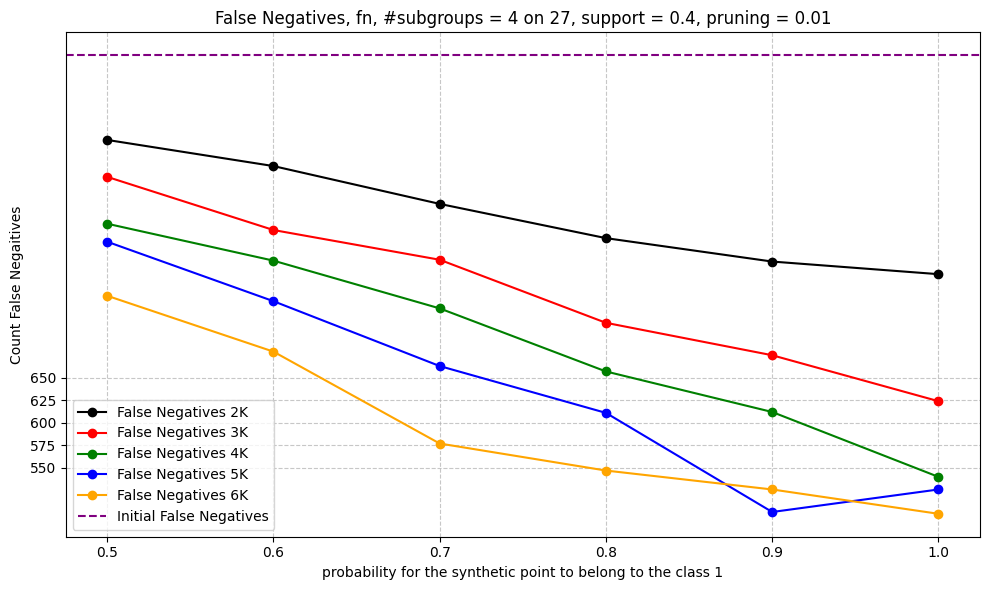

In [59]:
# Creazione del grafico
plt.figure(figsize=(10, 6))
p =[0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Linea per i falsi positivi





plt.plot(p, falsi_negativi_2K_fp_5sub, marker='o', label='False Negatives 2K  ', color='black')
plt.plot(p, falsi_negativi_3K_fp_5sub, marker='o', label='False Negatives 3K  ', color='red')
plt.plot(p, falsi_negativi_4K_fp_5sub, marker='o', label='False Negatives 4K  ', color='green')
plt.plot(p, falsi_negativi_5K_fp_5sub, marker='o', label='False Negatives 5K  ', color='blue')
plt.plot(p, falsi_negativi_6K_fp_5sub, marker='o', label='False Negatives 6K  ', color='orange')


plt.axhline(y=falsi_negativi_5K_fp_5sub_before, color='purple', linestyle='--', label='Initial False Negatives')

# Etichette e titolo
plt.xlabel('probability for the synthetic point to belong to the class 1')
plt.ylabel('Count False Negaitives')
plt.title(f'False Negatives, fn, #subgroups = {K} on {filtered_instances}, support = {min_sup}, pruning = {epsilon}')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.yticks(range(550, 660, 25))

# Mostra il grafico
plt.tight_layout()
plt.show()

In [60]:
count_0, count_1

(3574, 534)